# Model tuning

##### We will perform small experiments to determine the optimal size of the transformer (n_heads, n_layers, n_embd).

In [11]:
import sys, os
import torch
import numpy as np
import time
import importlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [16]:
# Import custom modules
sys.path.append(os.path.abspath('..'))
from utils.data_loader import get_batch, encode, decode, load_data
from utils.train_step import train_model
from Models.transformer_large import CharTransformerLarge

In [5]:
# Load data
train_data, test_data, ctoi, itoc, vocab_size = load_data('../data/encoded.pkl')

In [6]:
# Split train data into train and validation sets
print(f'===== Splitting data into training and validation sets =====')
train_split, val_split = train_test_split(train_data, test_size=0.1, random_state=11)
print(f'Training data size: {train_split.size(0)} | Validation data size: {val_split.size(0)}')

===== Splitting data into training and validation sets =====
Training data size: 81000000 | Validation data size: 9000000


In [9]:
# Further split train_split into size of 10M for faster experiments. Random
print(f'===== Reducing training data size to 10M for faster experiments =====')
train_split, _ = train_test_split(train_split, train_size=10_000_000, random_state=11)
print(f'Reduced training data size: {train_split.size(0)}')

===== Reducing training data size to 10M for faster experiments =====
Reduced training data size: 10000000


Experimentation

In [10]:
# Define architecture config to sweep over
arch_configs = [
    {
        "n_embd": 128,
        "n_head": 2,
        "n_layer": 2
    },
    {
        "n_embd": 256,
        "n_head": 4,
        "n_layer": 2
    },
    {
        "n_embd": 256,
        "n_head": 4,
        "n_layer": 4
    },
    {
        "n_embd": 512,
        "n_head": 8,
        "n_layer": 4
    },
    {
        "n_embd": 512,
        "n_head": 8,
        "n_layer": 6
    }
]

In [61]:
# Define hyperparameters
base_hyperparams = {
    "batch_size": 128,
    "seq_len": 64,
    "niter": 100
}

In [41]:
# Define function for training and evaluating models with different architectures
def run_architecture_experiments(train_data, val_data):
    all_results = []
    for config in arch_configs:
        print(f"\n Running architecture: {config}")

        # Create model
        model = CharTransformerLarge(vocab_size, **config) # Unpack config dictionary

        # Create optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)

        # Train and collect metrics
        start_time = time.time()
        results = train_model(model, train_data, val_data, optimizer, hyperparams=base_hyperparams)
        end_time = time.time()

        # Compute total tokens processed
        total_tokens = base_hyperparams["niter"] * base_hyperparams["batch_size"] * base_hyperparams["seq_len"]

        # Aggregate summary statistics
        results_summary = {
            "architecture": config,
            "train_time_sec": end_time - start_time,
            "total_tokens": total_tokens,
            "train_loss": results['train_loss'],
            "val_loss": results['val_loss'],
            "train_acc": results['train_acc'],
            "val_acc": results['val_acc']
        }
        
        all_results.append(results_summary)

    return all_results


run experiment

In [44]:
experiment_results = run_architecture_experiments(train_split, val_split)


 Running architecture: {'n_embd': 128, 'n_head': 2, 'n_layer': 2}

===== Training CharTransformerLarge =====
Device: cuda | Iterations: 500

[Iteration 1/500 | Time   3.2s]
Train Loss: 82.8362 | Train Acc: 7.1% 	 Validation Loss: 33.3330 | Validation Acc: 17.4%

[Iteration 100/500 | Time   7.7s]
Train Loss: 2.8671 | Train Acc: 17.5% 	 Validation Loss: 2.8692 | Validation Acc: 17.7%

[Iteration 200/500 | Time  12.0s]
Train Loss: 2.8677 | Train Acc: 16.8% 	 Validation Loss: 2.8766 | Validation Acc: 17.3%

[Iteration 300/500 | Time  16.4s]
Train Loss: 2.8642 | Train Acc: 17.3% 	 Validation Loss: 2.8656 | Validation Acc: 17.1%

[Iteration 400/500 | Time  20.7s]
Train Loss: 2.8650 | Train Acc: 16.8% 	 Validation Loss: 2.8647 | Validation Acc: 16.7%

[Iteration 500/500 | Time  25.1s]
Train Loss: 2.8575 | Train Acc: 17.5% 	 Validation Loss: 2.8460 | Validation Acc: 17.2%

===== Finished Training CharTransformerLarge =====


 Running architecture: {'n_embd': 256, 'n_head': 4, 'n_layer': 2}

=

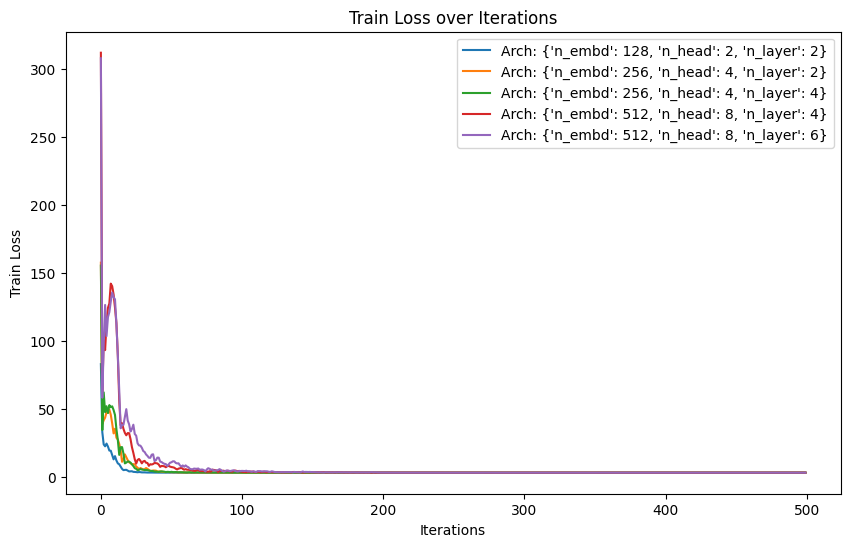

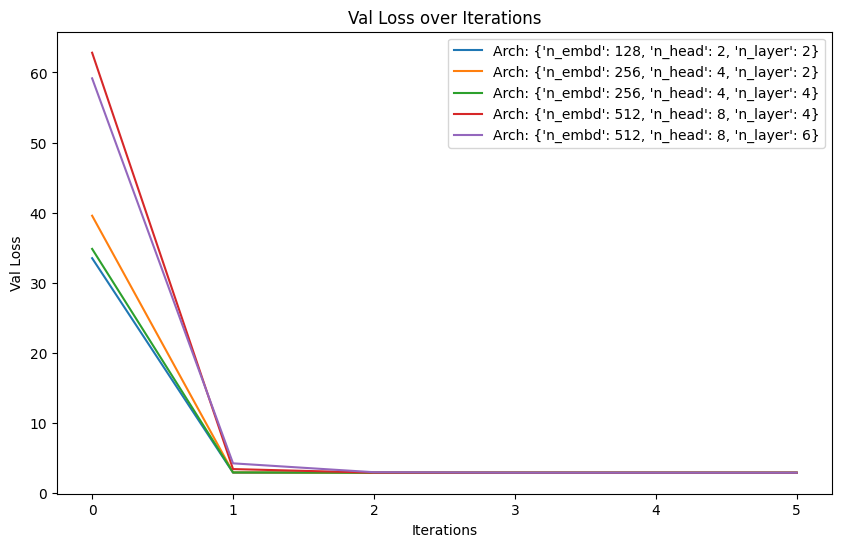

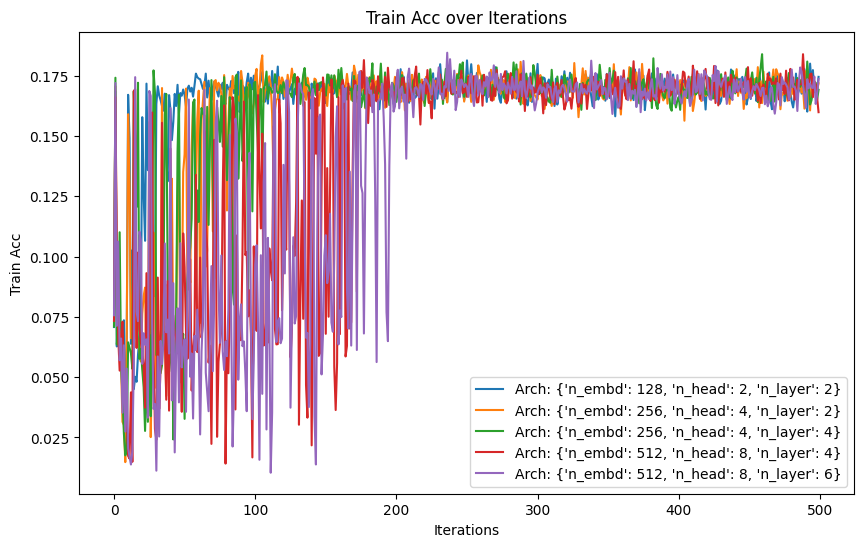

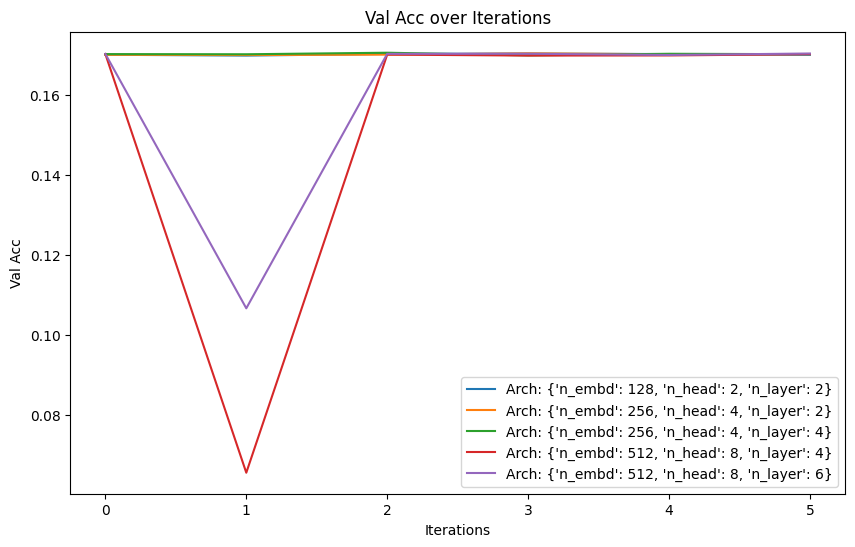

In [57]:
# Plot results for each architecture
for metric in ['train_loss', 'val_loss', 'train_acc', 'val_acc']:
    plt.figure(figsize=(10, 6))
    for result in experiment_results:
        plt.plot(result[metric], label=f"Arch: {result['architecture']}")
    plt.title(f"{metric.replace('_', ' ').title()} over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    plt.show()